# Introduction

## 1. Project Overview

The aim of this project is to build different unsupervised learning models for the purpose of topic modelling with a dataset of our choice. Afterwards, we will proceed to compare the different models by running them through a classification model. The methods we decided to work with are Latent Dirichlet Allocation (LDA) and Word2Vec.

We chose to look into Amazon book reviews in order to analyse whether you could predict the sentiment of a review from just the title, or was it necessary to read the whole review too. 

We found an appropriate [book review dataset](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?fbclid=IwAR3MXEuWxr3_mE1F27D9IvIy_0zdctqMPbIPS2oll9gy7Gv270cpwBViJVg&select=books_data.csv) that covered the main criteria we were looking for. Our criteria were:
* The first was that there was a large enough number of observations, which in this case was 3,000,000.
* The second was that there were no null entries in the book rating column. This is because the primary aim of our task was to create a suitable topic model, rather than explore how to impute missing ratings.
* Lastly, was to make sure that all reviews were in English, to ensure we could form suitable topic models.

A preview of this is given below to highlight the original form of the dataset. As the dataset is very large, we cannot load it in automatically by, for example, a google drive link. Therefore, to run any lines which read in a dataset, like the one below, make sure to have the dataset downloaded to your working directory of your machine. Our datasets can be found in this [Google Drive folder](https://drive.google.com/drive/u/0/folders/1a34kpRyqhbxBmbiLMoh7KdzgfvqozoO8).

Our plan for comparing the two topic modelling methods was to use each of the outputs as features for a classification model. We would then inspect their ROC curves initially, and use this to inform our inspection of different performance metrics. For this specific dataset we did not believe there was a significant difference in impact between false positives and false negatives, hence we did not reweight recall and precision. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
book_data = pd.read_csv('Books_rating.csv',engine='python',error_bad_lines=False)
print('\033[1m' + "Sample of the Amazon Book Review dataset:")
book_data.head()

C:\Users\Team Knowhow\AppData\Local\Temp\ipykernel_21264\2407891746.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  book_data = pd.read_csv('Books_rating.csv',engine='python',error_bad_lines=False)
Skipping line 68779: unexpected end of data


Sample of the Amazon Book Review dataset:


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [3]:
orig_df = pd.DataFrame(book_data)

## 2. Our Data

The original dataset from Kaggle had not been cleaned. Instead, we adapted other code in combination with code from the workshop to preprocess the text data.
Upon initial investigation of the data, we found that there was 38 null entries for the review summary and 8 null entries for the review text. As this accounted for such a small percentage of the dataset, we decided to remove any columns which had null entries for either of these columns. Furthermore, as LDA represents each document as a mixture of topics, it did not make sense to include the null entries as the topic distribution would be 0. The rest of our preprocessing included:

* Removing stopwords (e.g., 'the', 'is'),
* Removing punctuation,
* Removing emojis,
* Restore common abbreviations,
* Converting all characters to lowercase,
* Removing short words not captured by stopwords,
* Removing numerical characters,
* Tokenisation,
* Lemmatisation.



Piechart of the original Training set's Book Scores (1-5):


([<matplotlib.patches.Wedge at 0x1ae4ee03820>,
 [Text(-0.36077028919201587, 1.0391558104713217, '5.0'),
  Text(-0.31477391630011986, -1.0540006554158707, '4.0'),
  Text(0.6063065680297778, -0.9178193425527448, '3.0'),
  Text(0.953977524156105, -0.5476558074237762, '1.0'),
  Text(1.086211234231676, -0.17362360043755334, '2.0')],
 [Text(-0.1967837941047359, 0.5668122602570844, '60.64%'),
  Text(-0.17169486343642898, -0.5749094484086568, '19.49%'),
  Text(0.3307126734707878, -0.5006287323014971, '8.33%'),
  Text(0.5203513768124209, -0.29872134950387785, '6.50%'),
  Text(0.5924788550354596, -0.09470378205684726, '5.05%')])

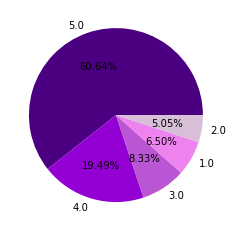

In [4]:
colors = ['indigo', 'darkviolet','mediumorchid','violet','thistle']
labels = orig_df['review/score'].value_counts().keys().map(str)
values = orig_df['review/score'].value_counts()
print('\033[1m' + "Piechart of the original Training set's Book Scores (1-5):")
plt.pie(values,colors=colors,labels=labels,autopct='%1.2f%%')

We decided to convert the review scores to binary scores, where 0 represented score 1-3 and 1 represented scores 4-5. This transformed our classification into a binary classification task. We decided to do this for a few reasons, one being that the 5 classes were very imbalanced. We therefore thought it best to group the scores 1-3 together. Intuitively, this makes sense as we believed scores 1-3 represented negative book reviews whereas we deemed a score of 4 or 5 as positive. Furthermore, we thought metrics on the binary labels (such as ROC and accuracy) would be more informative then the mean squared error (over the 5 original classes).


After cleaning the data, we created two files. One contained just the review summaries, whereas the other contained concatenated text on both the review summaries and review text.

Finally, we split our data using a stratified train test split. We created the train set from a random 80% sample of the full dataset and left the rest as our test set (see Test-Training-Preparation.ipynb).

This is a preview of 5 rows of the processed data, specifically the file containing the summaries and text combined.

In [6]:
cleaned_data = pd.read_csv('data_cleaned_full_text_and_summaries.csv')
print('\033[1m' + "Sample of the Preprocessed Book Review dataset:")
cleaned_data.head()

KeyboardInterrupt: 

## 3. Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

To begin the investigation, the code below gives us information about the dataset size. 

In [ ]:
cleaned_data.shape

In [ ]:
df = pd.DataFrame(cleaned_data)

Below shows that there are no null entries (as we removed them in the data cleaning step).

In [ ]:
df.isna().sum()

Below shows the number of positive reviews contrasted against the number of negative reviews. As you can see, our dataset has a large class imbalance as there are many more positive reviews. We will consider this throughout this project through weighting measures in our classification models, our choice of performance metric and how we downsample our data.

In [ ]:
print(df.sentiment.value_counts())
p=df.sentiment.value_counts().plot(kind="bar")

Here is an example of a tokenised summary concatenated with the review text also. This book review was labelled 0 (negative).

In [ ]:
df.iloc[2,1]

To highlight common words within the reviews, we utilised python's WordCloud package ([WordCloud tutorial](https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/)). The code below takes a while to run.

In [ ]:
df['combine']=df['text'].apply(lambda x: ' '.join(x))
all_words = " ".join(sent for sent in df['combine'])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()